In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [9]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> CNN1 - GRU 1 </h1>

In [12]:
from tensorflow.keras.layers import GRU
model = Sequential()
# CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_1 (Dropout)         (None, 126, 64)           0         
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 84934 (331.77 KB)
Trainable params: 8493

In [13]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 8s 28ms/step - loss: 1.1474 - accuracy: 0.5144 - val_loss: 0.6598 - val_accuracy: 0.6378
Epoch 2/10
58/58 [==============================] - 1s 13ms/step - loss: 0.6056 - accuracy: 0.7025 - val_loss: 0.4869 - val_accuracy: 0.7960
Epoch 3/10
58/58 [==============================] - 1s 12ms/step - loss: 0.4563 - accuracy: 0.7875 - val_loss: 0.3910 - val_accuracy: 0.8223
Epoch 4/10
58/58 [==============================] - 1s 11ms/step - loss: 0.3535 - accuracy: 0.8464 - val_loss: 0.2840 - val_accuracy: 0.8830
Epoch 5/10
58/58 [==============================] - 1s 16ms/step - loss: 0.2525 - accuracy: 0.9027 - val_loss: 0.3106 - val_accuracy: 0.8744
Epoch 6/10
58/58 [==============================] - 1s 18ms/step - loss: 0.1969 - accuracy: 0.9260 - val_loss: 0.1640 - val_accuracy: 0.9302
Epoch 7/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1737 - accuracy: 0.9339 - val_loss: 0.2245 - val_accuracy: 0.9125
Epoch 8/10
58

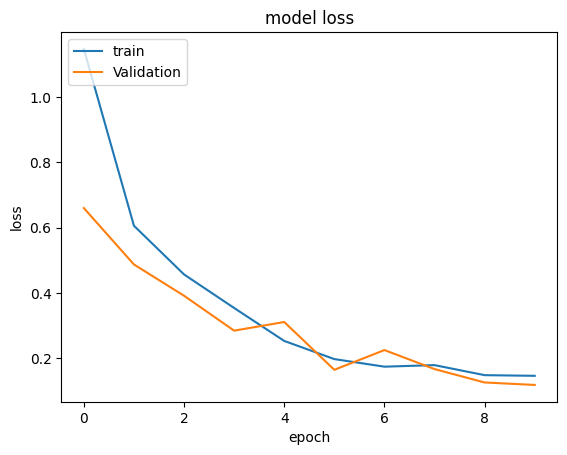

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

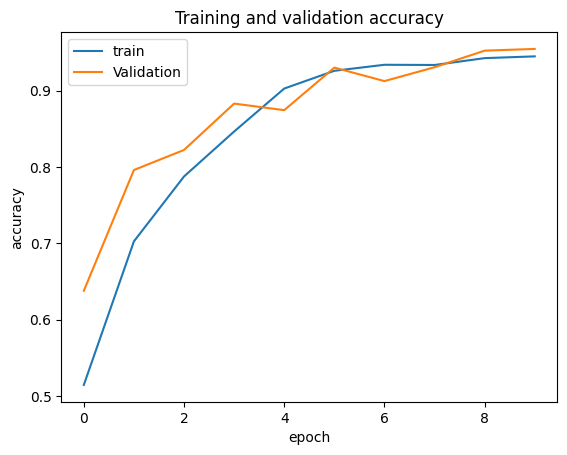

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[482   1  13   0   0   0]
 [ 22 416  33   0   0   0]
 [  8  17 395   0   0   0]
 [  0  22   4 384  81   0]
 [  0   0   0  96 436   0]
 [  0   0   1   0   0 536]]
0.8988802171700034
0.8983052843861745
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       496
           1       0.91      0.88      0.90       471
           2       0.89      0.94      0.91       420
           3       0.80      0.78      0.79       491
           4       0.84      0.82      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

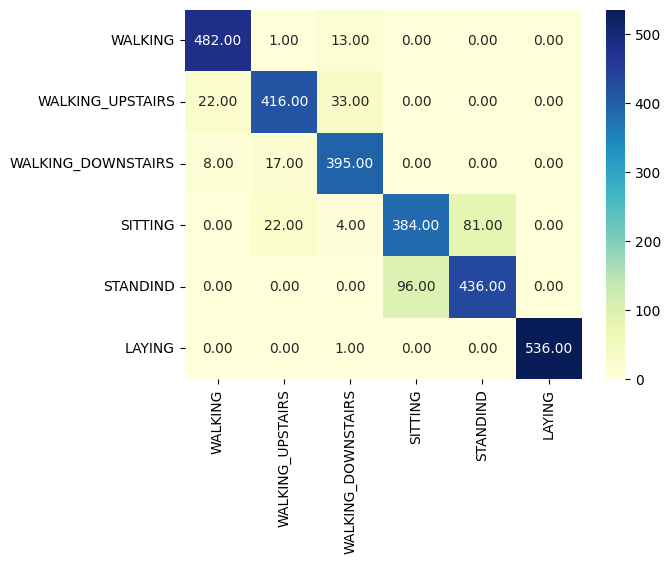

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN1 - GRU2 </h1>


In [17]:
# Model 2
model = Sequential()
# CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_3 (Dropout)         (None, 126, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 126, 128)          74496     
                                                                 
 dropout_4 (Dropout)         (None, 126, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 11s 48ms/step - loss: 1.0472 - accuracy: 0.5477 - val_loss: 0.5978 - val_accuracy: 0.7348
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.5574 - accuracy: 0.7482 - val_loss: 0.3951 - val_accuracy: 0.8318
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.3518 - accuracy: 0.8575 - val_loss: 0.2534 - val_accuracy: 0.9066
Epoch 4/10
58/58 [==============================] - 2s 32ms/step - loss: 0.2433 - accuracy: 0.9086 - val_loss: 0.1847 - val_accuracy: 0.9229
Epoch 5/10
58/58 [==============================] - 2s 33ms/step - loss: 0.1873 - accuracy: 0.9332 - val_loss: 0.1495 - val_accuracy: 0.9379
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1636 - accuracy: 0.9378 - val_loss: 0.1369 - val_accuracy: 0.9497
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1676 - accuracy: 0.9351 - val_loss: 0.1437 - val_accuracy: 0.9406
Epoch 8/10
5

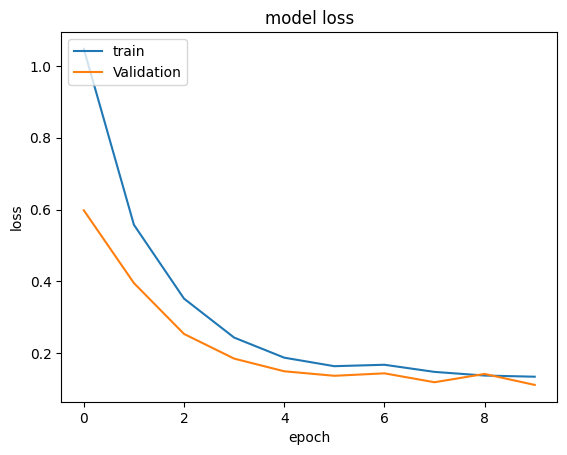

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

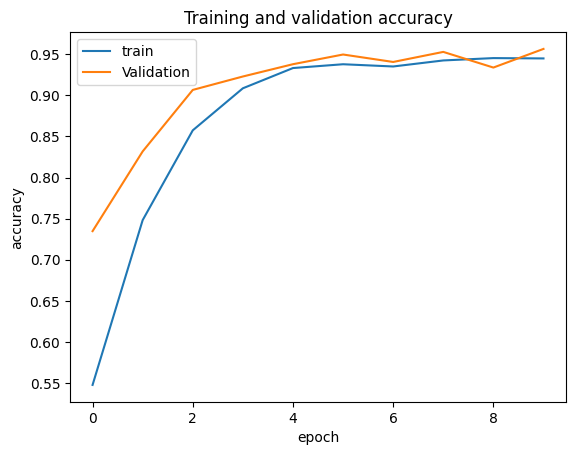

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 10ms/step
[[472   7  17   0   0   0]
 [ 13 420  38   0   0   0]
 [ 15   5 400   0   0   0]
 [  2  25   0 415  49   0]
 [  1   9   0 114 408   0]
 [  0  27   0   0   0 510]]
0.8907363420427553
0.89064779517614
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       496
           1       0.85      0.89      0.87       471
           2       0.88      0.95      0.91       420
           3       0.78      0.85      0.81       491
           4       0.89      0.77      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

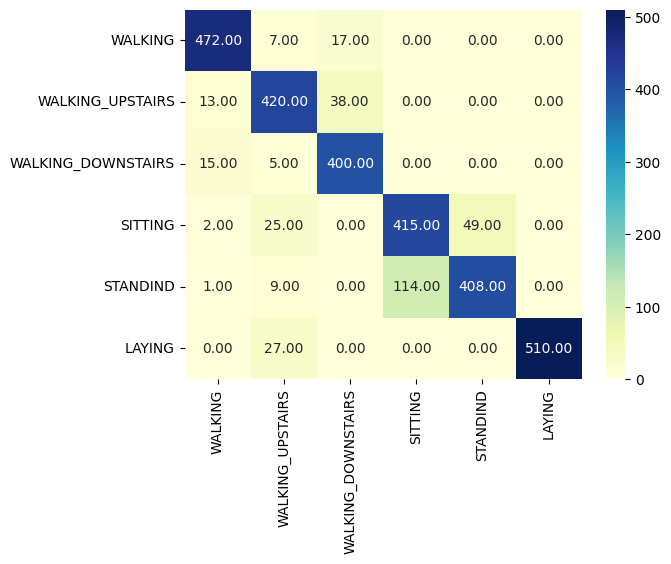

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2 - GRU1</h1>

In [23]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_9 (Dropout)         (None, 126, 64)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_10 (Dropout)        (None, 124, 64)           0         
                                                                 
 gru_4 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 8s 47ms/step - loss: 1.1044 - accuracy: 0.5209 - val_loss: 0.5968 - val_accuracy: 0.7194
Epoch 2/10
58/58 [==============================] - 1s 16ms/step - loss: 0.5575 - accuracy: 0.7380 - val_loss: 0.5257 - val_accuracy: 0.7779
Epoch 3/10
58/58 [==============================] - 1s 14ms/step - loss: 0.3615 - accuracy: 0.8513 - val_loss: 0.2995 - val_accuracy: 0.8898
Epoch 4/10
58/58 [==============================] - 1s 13ms/step - loss: 0.2504 - accuracy: 0.9029 - val_loss: 0.2229 - val_accuracy: 0.9225
Epoch 5/10
58/58 [==============================] - 1s 16ms/step - loss: 0.2136 - accuracy: 0.9196 - val_loss: 0.2194 - val_accuracy: 0.9184
Epoch 6/10
58/58 [==============================] - 1s 15ms/step - loss: 0.1775 - accuracy: 0.9351 - val_loss: 0.1538 - val_accuracy: 0.9456
Epoch 7/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1627 - accuracy: 0.9396 - val_loss: 0.1575 - val_accuracy: 0.9424
Epoch 8/10
58

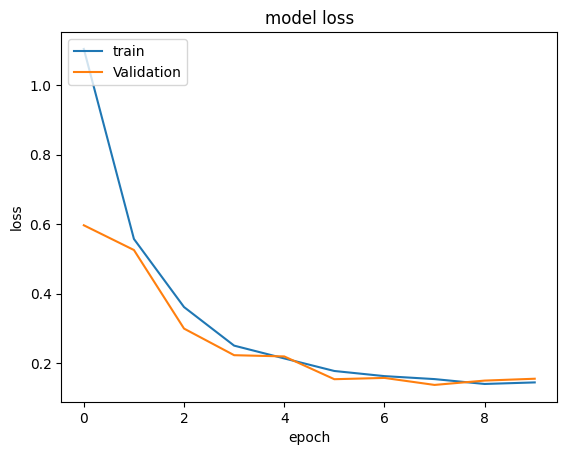

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

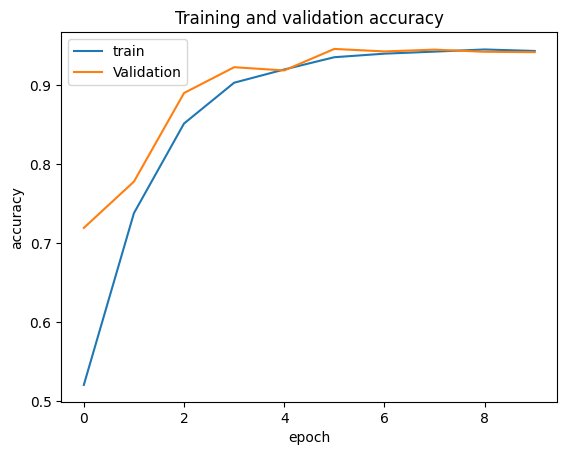

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 7ms/step
[[467   9   3   0  17   0]
 [ 18 429  21   0   3   0]
 [ 15  10 395   0   0   0]
 [  0  23   2 352 114   0]
 [  0   0   0  72 460   0]
 [  0  17   9   0   0 511]]
0.8870037326094333
0.8866631795067573
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       496
           1       0.88      0.91      0.89       471
           2       0.92      0.94      0.93       420
           3       0.83      0.72      0.77       491
           4       0.77      0.86      0.82       532
           5       1.00      0.95      0.98       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

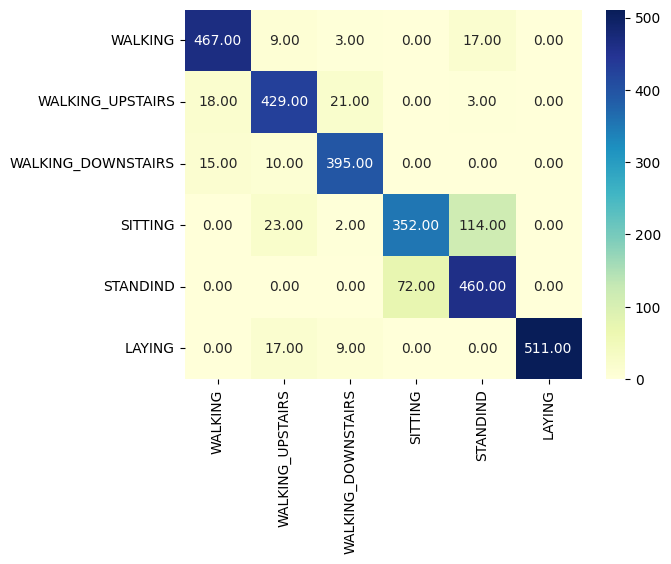

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN2 - GRU2 </h1>

In [29]:
# Model 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_14 (Dropout)        (None, 126, 64)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_15 (Dropout)        (None, 124, 64)           0         
                                                                 
 gru_6 (GRU)                 (None, 124, 128)          74496     
                                                                 
 dropout_16 (Dropout)        (None, 124, 128)          0         
                                                                 
 gru_7 (GRU)                 (None, 128)              

In [30]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 11s 52ms/step - loss: 1.0818 - accuracy: 0.5126 - val_loss: 0.7070 - val_accuracy: 0.6473
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.5926 - accuracy: 0.7186 - val_loss: 0.4878 - val_accuracy: 0.8010
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.4369 - accuracy: 0.8058 - val_loss: 0.3275 - val_accuracy: 0.8690
Epoch 4/10
58/58 [==============================] - 2s 40ms/step - loss: 0.3214 - accuracy: 0.8721 - val_loss: 0.3531 - val_accuracy: 0.8549
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 0.2447 - accuracy: 0.9041 - val_loss: 0.1656 - val_accuracy: 0.9415
Epoch 6/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1797 - accuracy: 0.9293 - val_loss: 0.1559 - val_accuracy: 0.9320
Epoch 7/10
58/58 [==============================] - 2s 32ms/step - loss: 0.1653 - accuracy: 0.9347 - val_loss: 0.1354 - val_accuracy: 0.9420
Epoch 8/10
5

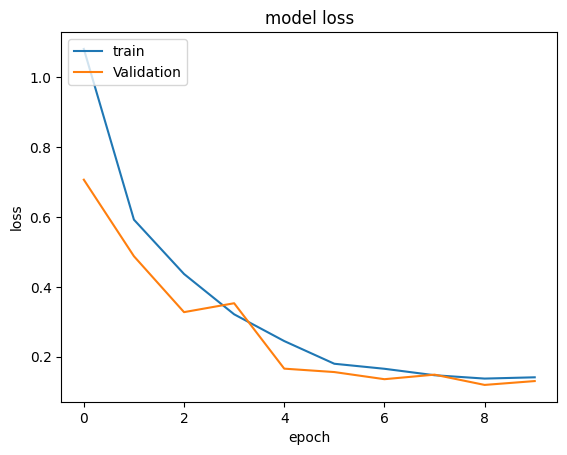

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

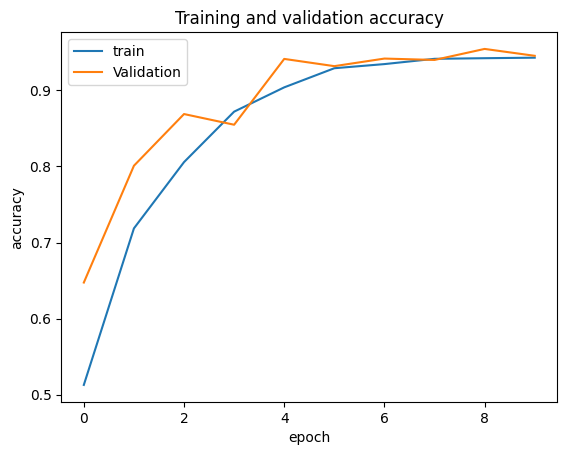

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 11ms/step
[[461  28   7   0   0   0]
 [ 17 444  10   0   0   0]
 [  3  31 386   0   0   0]
 [  5  23   0 355 108   0]
 [  2   2   0  57 471   0]
 [  0   0  28   0   0 509]]
0.8910756701730573
0.8904590234954315
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       496
           1       0.84      0.94      0.89       471
           2       0.90      0.92      0.91       420
           3       0.86      0.72      0.79       491
           4       0.81      0.89      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

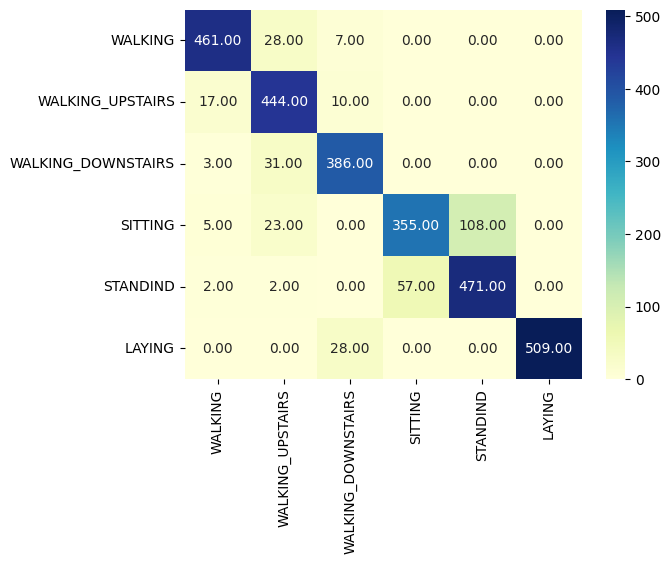

In [33]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN3-GRU3 </h1>

In [34]:
# Model 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(trainy_one_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 dropout_18 (Dropout)        (None, 126, 64)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 dropout_19 (Dropout)        (None, 124, 64)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 122, 64)           12352     
                                                                 
 dropout_20 (Dropout)        (None, 122, 64)           0         
                                                                 
 gru_8 (GRU)                 (None, 122, 128)         

In [35]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 18s 121ms/step - loss: 1.1900 - accuracy: 0.4920 - val_loss: 0.6128 - val_accuracy: 0.7194
Epoch 2/10
58/58 [==============================] - 2s 39ms/step - loss: 0.5329 - accuracy: 0.7610 - val_loss: 0.5929 - val_accuracy: 0.7965
Epoch 3/10
58/58 [==============================] - 2s 38ms/step - loss: 0.3509 - accuracy: 0.8629 - val_loss: 0.2021 - val_accuracy: 0.9338
Epoch 4/10
58/58 [==============================] - 3s 45ms/step - loss: 0.2226 - accuracy: 0.9192 - val_loss: 0.1994 - val_accuracy: 0.9320
Epoch 5/10
58/58 [==============================] - 3s 53ms/step - loss: 0.1937 - accuracy: 0.9290 - val_loss: 0.2205 - val_accuracy: 0.9125
Epoch 6/10
58/58 [==============================] - 3s 53ms/step - loss: 0.1705 - accuracy: 0.9329 - val_loss: 0.1278 - val_accuracy: 0.9451
Epoch 7/10
58/58 [==============================] - 2s 36ms/step - loss: 0.1690 - accuracy: 0.9348 - val_loss: 0.1386 - val_accuracy: 0.9456
Epoch 8/10


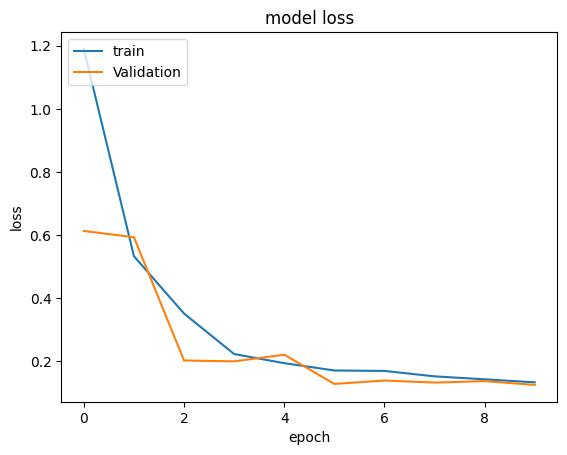

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

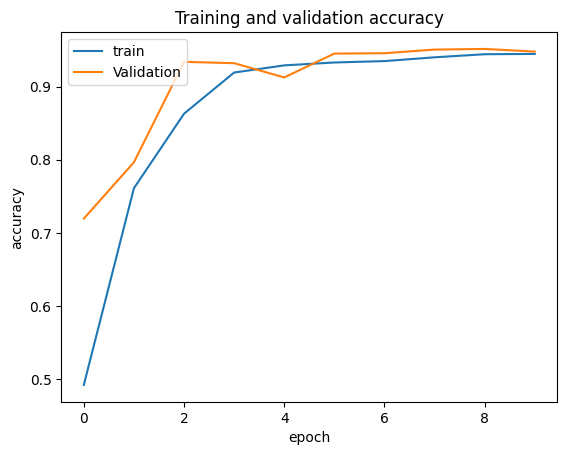

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 9ms/step
[[405  40  50   0   1   0]
 [  1 422  48   0   0   0]
 [  2   1 417   0   0   0]
 [  0   5   3 369 114   0]
 [  0   0   0  89 443   0]
 [  0   0   0   0   0 537]]
0.8798778418730913
0.8796980951447682
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       496
           1       0.90      0.90      0.90       471
           2       0.81      0.99      0.89       420
           3       0.81      0.75      0.78       491
           4       0.79      0.83      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

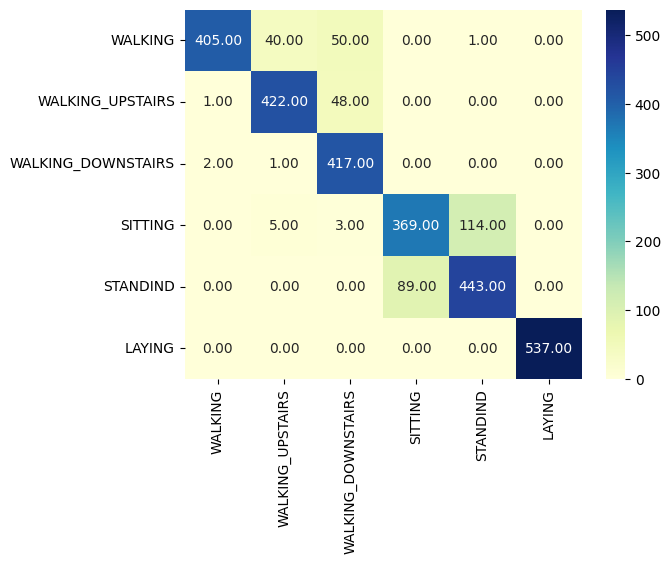

In [38]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')